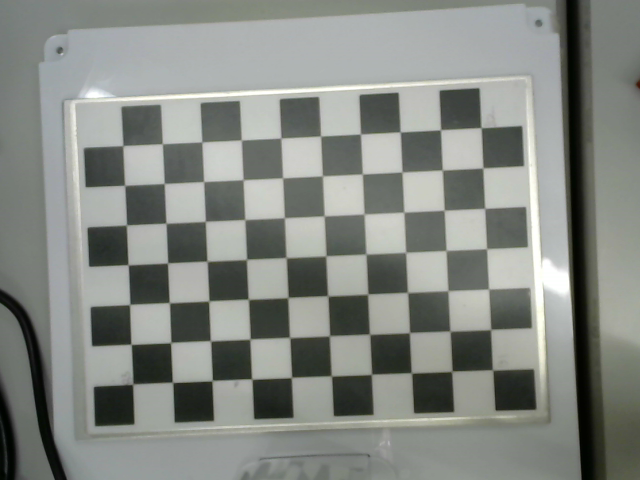

In [52]:
# -*- coding:utf-8 -*-

#
# (1) カメラから画像をキャプチャするプログラム
#

%matplotlib inline
import cv2 #　opencvのインポート
import matplotlib.pyplot as plt # matplotlib(描画用)
import numpy as np
from IPython.display import display, Image

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

def capture_camera(camid=0, mirror=True, size=None):
    """Capture video from camera"""
    # カメラをキャプチャする
    cap = cv2.VideoCapture(camid) # 0はカメラのデバイス番号
    frameIdx = 0
    while True:
        # retは画像を取得成功フラグ
        ret, frame = cap.read()

        # 鏡のように映るか否か
        if mirror is True:
            frame = frame[:,::-1]

        # フレームをリサイズ
        # sizeは例えば(800, 600)
        if size is not None and len(size) == 2:
            frame = cv2.resize(frame, size)

        # フレームを表示する
        cv2.imshow('camera capture', frame)

        k = cv2.waitKey(1) # 1msec待つ
        if k == 27: # ESCキーで終了
            cv2.imwrite('camera.png', frame)
            break
        
        #if frameIdx > 30: # ESCキーで終了
        #    cv2.imwrite('camera.png', frame)
        #    break
            
        frameIdx = frameIdx + 1
        
    # キャプチャを解放する
    cap.release()
    cv2.destroyAllWindows()

        
if __name__ == '__main__':
    srcimgFilename = 'camera.png'
    capture_camera(camid=1, mirror=False)
    image = cv2.imread(srcimgFilename)
    display_cv_image(image, srcimgFilename)


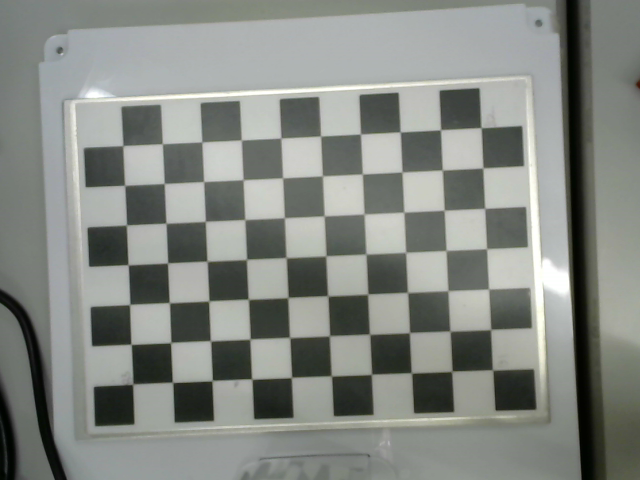

[492.59763 369.97232]
[481.01352 127.7047 ]
[132.78394 384.26056]
0.3793119714511547
0.38322978232084876


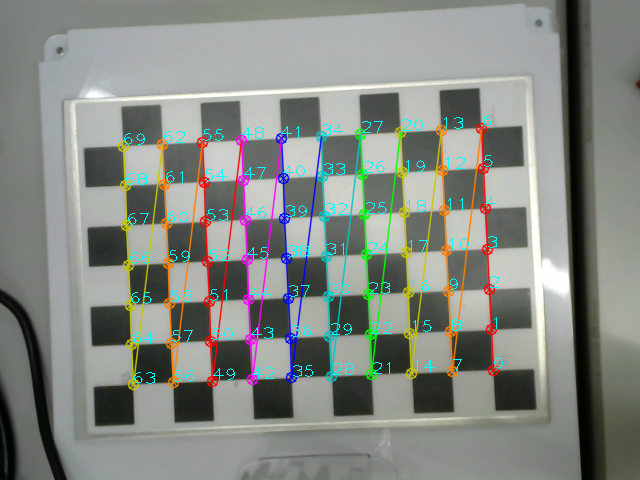

b'\x8d\xc0\x95W\x95\xcf\x8a\xb7\x81F83[ms]\r\n'


In [53]:
# -*- coding:utf-8 -*-

#
# (2) カメラからチェッカーボードを検出するプログラム
#

%matplotlib inline
import cv2 #　opencvのインポート
import matplotlib.pyplot as plt # matplotlib(描画用)
import numpy as np
from IPython.display import display, Image
import math

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

def detectChecker(fname):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    square_size = 1.0      # 正方形のサイズ
    pattern_size = (7, 10)  # 模様のサイズ
    img = cv2.imread(fname)
    img_w_checker = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # チェッカーボードからその交点を取得する
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    # チェッカーボード上の交点が見つかった場合のループ
    if ret == True:
        objpoints.append(objp)

        #corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        corners2 = cv2.cornerSubPix(gray,corners,(5,5),(-1,-1),criteria)
        
        # 取得したチェッカー点群のソートする
        # 画像右下からインデックスを付与する
        tmp = []
        length=0
        j=0
        for i in range(pattern_size[1]-1,-1,-1):
            for j in range(0, pattern_size[0]):
                #np.insert(tmp,idx, corners2[j+(i*pattern_size[1])], axis=0)
                idx = j+(i*pattern_size[0])
                #print(length, idx)
                length = length + 1
                #np.insert(tmp, idx, corners2[idx], axis=0)
                #print(idx, corners2[idx])
                tmp.append(corners2[idx])
                
        corners2 = np.array(tmp)
        
        
        #画像-実空間のスケーリングパラメータの算出
        p0 = corners2[0]
        p6 = corners2[6]
        p63 = corners2[63]
        print(p0[0])
        print(p6[0])
        print(p63[0])
        
        length_x = 92 #mm
        length_y = 138 #mm
        scale_x = math.sqrt((p0[0][0] - p6[0][0])*(p0[0][0] - p6[0][0]) + (p0[0][1] - p6[0][1])*(p0[0][1] - p6[0][1]))
        scale_y = math.sqrt((p0[0][0] - p63[0][0])*(p0[0][0] - p63[0][0]) + (p0[0][1] - p63[0][1])*(p0[0][1] - p63[0][1]))

        scale_x = length_x/scale_x
        scale_y = length_y/scale_y
        print(scale_x)
        print(scale_y)
        f = open('scale.csv','w')
        f.write(str(scale_x))
        f.write(',')
        f.write(str(scale_y))
        f.write('\n')
        f.close()
        
        #imgpoints.append(corners2)

        # Draw and display the corners
        img_w_checker = cv2.drawChessboardCorners(img_w_checker, pattern_size, corners2, ret)
        #cv2.imshow('img',img_w_checker)
        #cv2.waitKey(500)
        #plt.imshow(img_w_checker) #表示
        cfname = 'checkerimage.png'
        
        #チェッカー座標の書き出し
        f = open('checkerPoints.csv','w')
        for i in range(0,len(corners2)):
            items = list(corners2[i][0])
            f.write(str(items[0]*scale_x))
            f.write(',')
            f.write(str(items[1]*scale_y))
            f.write(',0.0\n')
        f.close()
        
        #文字の書き込み
        font_size = 1.0
        font = cv2.FONT_HERSHEY_PLAIN
        n = 0
        for cp in corners2:
            p = cp[0]
            #print(p)
            cv2.putText(img_w_checker,str(n),(p[0],p[1]),font, font_size,(255,255,0))
            
            n = n + 1
            
        cv2.imwrite(cfname, img_w_checker)
        
        
        
        
        return cfname
        
def GetTransFormMat():
    import subprocess
    #
    # 外部プロセスでカメラ->ロボットの座標変換行列を同定する
    #    
    try:
        res = subprocess.check_output('./SVD/svd.exe teachPoints.csv checkerPoints.csv')
        print(res)
        
    except:
        print("Error.")
    
if __name__ == '__main__':
    srcimgFilename = 'camera.png'
    
    image = cv2.imread(srcimgFilename)
    display_cv_image(image, srcimgFilename)
    
    checkerimageFilename = detectChecker(srcimgFilename)
    checkerImage = cv2.imread(checkerimageFilename)    
    display_cv_image(checkerImage, checkerimageFilename)

    GetTransFormMat()
    
    
    #CreateTeachPoints(size=(7,10),teachFileName='teachPoints.csv')

In [25]:
# -*- coding:utf-8 -*-

#
# (3) ロボットのリモート制御を行うプログラム
#

import socket

host = "127.0.0.1" #お使いのサーバーのホスト名を入れます
port = 5000 #適当なPORTを指定してあげます
client = socket.socket(socket.AF_INET, socket.SOCK_STREAM) #オブジェクトの作成をします
client.connect((host, port)) #これでサーバーに接続します
client.send(b"J,-900,0,0,0,0,200\n") #適当なデータを送信します（届く側にわかるように）
response = client.recv(4096) #適当な2の累乗にします（大きすぎるとダメ）

print(response)

ConnectionRefusedError: [WinError 10061] 対象のコンピューターによって拒否されたため、接続できませんでした。

In [3]:
# -*- coding:utf-8 -*-

#
# (4) 画像処理（色抽出）およびロボットの制御を行うプログラム
#

import cv2
from time import sleep
import numpy as np
import math
import socket
from IPython.display import display, Image

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))
    
def capture_camera(camid=0, mirror=True, size=None):
    """Capture video from camera"""
    # カメラをキャプチャする
    cap = cv2.VideoCapture(camid) # 0はカメラのデバイス番号
    frameIdx = 0
    while True:
        # retは画像を取得成功フラグ
        ret, frame = cap.read()

        # 鏡のように映るか否か
        if mirror is True:
            frame = frame[:,::-1]

        # フレームをリサイズ
        # sizeは例えば(800, 600)
        if size is not None and len(size) == 2:
            frame = cv2.resize(frame, size)

        # フレームを表示する
        #cv2.imshow('camera capture', frame)

        k = cv2.waitKey(1) # 1msec待つ
        if k == 27: # ESCキーで終了
            break
        
        if frameIdx > 30: # ESCキーで終了
            cv2.imwrite('camera.png', frame)
            break
        
            
        frameIdx = frameIdx + 1
        
    # キャプチャを解放する
    cap.release()
    #cv2.destroyAllWindows()

def ContoursFromImage(image):
    image, contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def find_rect_of_target_color(image):
    contours = ContoursFromImage(image)
    rects = []
    for contour in contours:
        approx = cv2.convexHull(contour)
        rect = cv2.boundingRect(approx)
        rects.append(np.array(rect))
        
    return rects

def extractcolorHLS(img):
    # 取得する色の範囲を指定する
    lower_blue = np.array([80, 100, 20])
    upper_blue = np.array([180, 255, 255])

    lower_red = np.array([0, 128, 0])
    upper_red = np.array([10, 255, 255])

    lower_yellow = np.array([20, 120, 120])
    upper_yellow = np.array([80, 255, 255])
    
    # フレームをHSVに変換
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 指定した色に基づいたマスク画像の生成
    img_mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    img_mask_red = cv2.inRange(hsv, lower_red, upper_red)
    img_mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    
    return img_mask_red,img_mask_blue,img_mask_yellow

def getMaxRect(mask):
    #display_cv_image(srcimg, srcimgFilename)
    rect1 = find_rect_of_target_color(mask)
    
    #print(rect1)
    #面積最大を探す
    maxSq = 0
    maxSqIdx = 0
    idx = 0
    for rect in rect1:
        sq = rect[2]*rect[3]
        if(sq > maxSq):
            maxSq = sq
            maxSqIdx=idx
        idx=idx+1
        
    if(maxSq > 200):
        return rect1[maxSqIdx]
    else:
        return null

def getRotation(src):
    image, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours)
    #print(contours[0])
    #rect2 = cv2.minAreaRect(contours[0]) 
    #print(rect2) 
    # 各輪郭に対する処理
    for i in range(0, len(contours)):
        # 輪郭の領域を計算
        area = cv2.contourArea(contours[i])

        # ノイズ（小さすぎる領域）と全体の輪郭（大きすぎる領域）を除外
        if area < 1e2 or 1e5 < area:
            continue

        # 輪郭を描画する
        cv2.drawContours(src, contours, i, (0, 0, 255), 2, 8, hierarchy, 0)

        # 輪郭データを浮動小数点型の配列に格納
        X = np.array(contours[i], dtype=np.float).reshape((contours[i].shape[0], contours[i].shape[2]))

        # PCA（１次元）
        mean, eigenvectors = cv2.PCACompute(X, mean=np.array([], dtype=np.float), maxComponents=1)

        # 主成分方向のベクトルを描画
        pt = (mean[0][0], mean[0][1])
        vec = (eigenvectors[0][0], eigenvectors[0][1])
        #drawAxis(src, pt, vec, (255, 255, 0), 150)
        #print(pt,vec)
        
        return pt,vec
    

def drawVec(img, pt, vec):
    # 終了点
    length = 50
    end_pt = (int(pt[0] + length * vec[0]), int(pt[1] + length * vec[1]))
    cv2.circle(img, (int(pt[0]), int(pt[1])), 5, (255,0,0), 2)
    cv2.line(img, (int(pt[0]), int(pt[1])), end_pt, (255,0,0), 2);
    
    return img


def ReadMat(filename):
    f = open(filename,'r')
    lines = f.readlines()
    f.close()
    
    mat = []
    for line in lines:
        line = line.replace('\r','').replace('\n','')
        items = line.split(',')
        row = []
        for j in items:
            row.append(float(j))
        mat.append(row)
        
    return mat
    
def Transform(RMat,tMat,imgPt):
    RMat = np.array(RMat)
    tMat = np.array(tMat)
    imgPt = np.array(imgPt)
    
    #print('RMat',RMat)
    #print('tMat',tMat)
    #print('imgPt',imgPt)
    
    robotPt = np.dot(RMat, imgPt) +tMat
    #print(robotPt)
    
    return robotPt

def RobotRef(command):
    return
    host = "127.0.0.1" #お使いのサーバーのホスト名を入れます
    port = 5000 #適当なPORTを指定してあげます
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM) #オブジェクトの作成をします
    client.connect((host, port)) #これでサーバーに接続します
    #client.send(b"J,-900,0,0,0,0,300\n") #適当なデータを送信します（届く側にわかるように）
    client.send(command) #適当なデータを送信します（届く側にわかるように）
    
    response = client.recv(4096) #適当な2の累乗にします（大きすぎるとダメ）

    print(response)
    
if __name__ == '__main__':
    srcimgFilename = 'camera.png'
    RobotRef(b"J,-900,0,0,0,0,300\n")
    
    capture_camera(camid=1, mirror=False)
    image = cv2.imread(srcimgFilename)
    #display_cv_image(image, srcimgFilename)
    
    srcimg = cv2.imread(srcimgFilename)
    
    #テスト
    '''
    A = np.array([[1, 2],[3, 4]])
    B = np.array([[5, 6], [7, 8]])
    C = A * B
    print(C)
    '''
    
    #並進・回転行列の読み込み
    scale = ReadMat('scale.csv')
    RMat = ReadMat('R.csv')
    tMat = ReadMat('t.csv')
    
    points = dict()
    
    mask1,mask2,mask3 = extractcolorHLS(srcimg)
    
    redImg = cv2.bitwise_and(srcimg, srcimg, mask=mask1)
    blueImg= cv2.bitwise_and(srcimg, srcimg, mask=mask2)
    yellowImg=cv2.bitwise_and(srcimg, srcimg, mask=mask3)
    # 入力画像から窓画像を切り取り
    #roi = img[y:y+h, x:x+w]    
    
    #赤領域の切り出し
    try:    
        rect = getMaxRect(mask1)
        cv2.rectangle(redImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
        roi = mask1[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        pt,vec = getRotation(roi)
        pt = (pt[0]+rect[0], pt[1]+rect[1])
        redImg = drawVec(redImg, pt, vec)
        points['red'] = (pt,vec)
    except:
        pass
    
    try:    
        #青領域の切り出し
        rect = getMaxRect(mask2)
        cv2.rectangle(blueImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
        roi = mask2[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        pt,vec = getRotation(roi)
        pt = (pt[0]+rect[0], pt[1]+rect[1])
        blueImg = drawVec(blueImg, pt, vec)
        points['blue'] = (pt,vec)
    except:
        pass
    
    try:    
        #黄領域の切り出し
        rect = getMaxRect(mask3)
        cv2.rectangle(yellowImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
        roi = mask3[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        pt,vec = getRotation(roi)
        pt = (pt[0]+rect[0], pt[1]+rect[1])
        yellowImg = drawVec(yellowImg, pt, vec)
        points['yellow'] = (pt,vec)
    except:
        pass
    
    #print(points)
    robotPts=[]
    for key, value in points.items():
        #print("key:", key, "-- value:", value )
        pt = value[0]
        vec = value[1]
        print("vec",vec)
        #r = [pt[0], pt[1], 1.0]
        #rp= [pt[0] + vec[0] , pt[1] + vec[1], 1.0]

        r = np.array([[pt[0]], [pt[1]], [1.0]])
        rp= np.array([[pt[0] + vec[0]] ,[pt[1] + vec[1]],[1.0]])
        
        rd = Transform(RMat,tMat, r)
        rpd = Transform(RMat,tMat, rp)
        #rd = np.dot(RMat, r)
        #rpd = np.dot(RMat, rp)
        print(rd)
        print(rpd)
        
        #angle = int(1800.0*Math.Atan2((r.Y - rp.Y), (r.X - rp.X))/Math.PI);
        #angle = int(1800.0*math.atan2((rd[1] - rpd[1]), (rd[0] - rpd[0]))/math.pi);
        angle = int(1800.0*math.atan2(vec[1], vec[0])/math.pi)
        
        '''
        if(angle > 900):
            angle = angle - 1800
        
        if (angle < -900):
            angle = angle + 1800   
        '''
        
        print(angle)
        p = np.array([[pt[0]],[pt[1]],[0.0]])
        p = scale[0]*p
        robotPts.append([Transform(RMat,tMat,p), angle])
        
    for item in robotPts:
        p = item[0]
        angle = item[1]
        #cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+','+str(p[2][0])+',0.0,0.0,0.0,200\n'
        cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+',0.0,' +str(angle)+ ',+30.0,0.0,200\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
        #ハンドの角度を合わせる
        #cmd = 'A,3,'+str(angle)+',200\n'
        #print('cmd:',cmd)
        #RobotRef(cmd.encode())
        #sleep(3)
        
    RobotRef(b"J,-900,0,0,0,0,300\n")
    
    #display_cv_image(srcimg, 'srcimg.png')
    #display_cv_image(redImg, 'mask1.png')
    #display_cv_image(blueImg, 'mask2.png')
    #display_cv_image(yellowImg, 'mask3.png')
    
    '''
    display_cv_image(mask1, 'mask1.png')
    display_cv_image(mask2, 'mask2.png')
    display_cv_image(mask3, 'mask3.png')
    '''
    
    img5 = cv2.vconcat([srcimg, blueImg])
    img6 = cv2.vconcat([redImg, yellowImg])
    img7 = cv2.hconcat([img5, img6])
    cv2.imwrite('output.jpg', img7)
    display_cv_image(img7, 'output.png')
    


error: OpenCV(3.4.2) c:\projects\opencv-python\opencv\modules\imgproc\src\color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'cv::CvtHelper<struct cv::Set<3,4,-1>,struct cv::Set<3,-1,-1>,struct cv::Set<0,5,-1>,2>::CvtHelper'


In [5]:
from IPython.display import display
import ipywidgets as widgets

import cv2
from time import sleep
import numpy as np
import math
import socket
from IPython.display import display, Image

out = widgets.Output()

def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))
    
def capture_camera(camid=0, mirror=True, size=None):
    """Capture video from camera"""
    # カメラをキャプチャする
    cap = cv2.VideoCapture(camid) # 0はカメラのデバイス番号
    frameIdx = 0
    while True:
        # retは画像を取得成功フラグ
        ret, frame = cap.read()

        # 鏡のように映るか否か
        if mirror is True:
            frame = frame[:,::-1]

        # フレームをリサイズ
        # sizeは例えば(800, 600)
        if size is not None and len(size) == 2:
            frame = cv2.resize(frame, size)

        # フレームを表示する
        #cv2.imshow('camera capture', frame)

        k = cv2.waitKey(1) # 1msec待つ
        if k == 27: # ESCキーで終了
            break
        
        if frameIdx > 30: # ESCキーで終了
            cv2.imwrite('camera.png', frame)
            break
        
            
        frameIdx = frameIdx + 1
        
    # キャプチャを解放する
    cap.release()
    #cv2.destroyAllWindows()

def ContoursFromImage(image):
    image, contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def find_rect_of_target_color(image):
    contours = ContoursFromImage(image)
    rects = []
    for contour in contours:
        approx = cv2.convexHull(contour)
        rect = cv2.boundingRect(approx)
        rects.append(np.array(rect))
        
    return rects

def extractcolorHLS(img):
    # 取得する色の範囲を指定する
    lower_blue = np.array([80, 100, 20])
    upper_blue = np.array([180, 255, 255])

    lower_red = np.array([0, 128, 0])
    upper_red = np.array([10, 255, 255])

    lower_yellow = np.array([20, 120, 120])
    upper_yellow = np.array([80, 255, 255])
    
    # フレームをHSVに変換
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 指定した色に基づいたマスク画像の生成
    img_mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    img_mask_red = cv2.inRange(hsv, lower_red, upper_red)
    img_mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    
    return img_mask_red,img_mask_blue,img_mask_yellow

def getMaxRect(mask):
    #display_cv_image(srcimg, srcimgFilename)
    rect1 = find_rect_of_target_color(mask)
    
    #print(rect1)
    #面積最大を探す
    maxSq = 0
    maxSqIdx = 0
    idx = 0
    for rect in rect1:
        sq = rect[2]*rect[3]
        if(sq > maxSq):
            maxSq = sq
            maxSqIdx=idx
        idx=idx+1
        
    if(maxSq > 200):
        return rect1[maxSqIdx]
    else:
        return null

def getRotation(src):
    image, contours, hierarchy = cv2.findContours(src, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours)
    #print(contours[0])
    #rect2 = cv2.minAreaRect(contours[0]) 
    #print(rect2) 
    # 各輪郭に対する処理
    for i in range(0, len(contours)):
        # 輪郭の領域を計算
        area = cv2.contourArea(contours[i])

        # ノイズ（小さすぎる領域）と全体の輪郭（大きすぎる領域）を除外
        if area < 1e2 or 1e5 < area:
            continue

        # 輪郭を描画する
        cv2.drawContours(src, contours, i, (0, 0, 255), 2, 8, hierarchy, 0)

        # 輪郭データを浮動小数点型の配列に格納
        X = np.array(contours[i], dtype=np.float).reshape((contours[i].shape[0], contours[i].shape[2]))

        # PCA（１次元）
        mean, eigenvectors = cv2.PCACompute(X, mean=np.array([], dtype=np.float), maxComponents=1)

        # 主成分方向のベクトルを描画
        pt = (mean[0][0], mean[0][1])
        vec = (eigenvectors[0][0], eigenvectors[0][1])
        #drawAxis(src, pt, vec, (255, 255, 0), 150)
        #print(pt,vec)
        
        return pt,vec
    

def drawVec(img, pt, vec):
    # 終了点
    length = 50
    end_pt = (int(pt[0] + length * vec[0]), int(pt[1] + length * vec[1]))
    cv2.circle(img, (int(pt[0]), int(pt[1])), 5, (255,0,0), 2)
    cv2.line(img, (int(pt[0]), int(pt[1])), end_pt, (255,0,0), 2);
    
    return img


def ReadMat(filename):
    f = open(filename,'r')
    lines = f.readlines()
    f.close()
    
    mat = []
    for line in lines:
        line = line.replace('\r','').replace('\n','')
        items = line.split(',')
        row = []
        for j in items:
            row.append(float(j))
        mat.append(row)
        
    return mat
    
def Transform(RMat,tMat,imgPt):
    RMat = np.array(RMat)
    tMat = np.array(tMat)
    imgPt = np.array(imgPt)
    
    #print('RMat',RMat)
    #print('tMat',tMat)
    #print('imgPt',imgPt)
    
    robotPt = np.dot(RMat, imgPt) +tMat
    #print(robotPt)
    
    return robotPt

def RobotRef(command):
    return
    host = "127.0.0.1" #お使いのサーバーのホスト名を入れます
    port = 5000 #適当なPORTを指定してあげます
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM) #オブジェクトの作成をします
    client.connect((host, port)) #これでサーバーに接続します
    #client.send(b"J,-900,0,0,0,0,300\n") #適当なデータを送信します（届く側にわかるように）
    client.send(command) #適当なデータを送信します（届く側にわかるように）
    
    response = client.recv(4096) #適当な2の累乗にします（大きすぎるとダメ）

    print(response)
def RobotRef(command):
    return
    host = "127.0.0.1" #お使いのサーバーのホスト名を入れます
    port = 5000 #適当なPORTを指定してあげます
    client = socket.socket(socket.AF_INET, socket.SOCK_STREAM) #オブジェクトの作成をします
    client.connect((host, port)) #これでサーバーに接続します
    #client.send(b"J,-900,0,0,0,0,300\n") #適当なデータを送信します（届く側にわかるように）
    client.send(command) #適当なデータを送信します（届く側にわかるように）
    
    response = client.recv(4096) #適当な2の累乗にします（大きすぎるとダメ）

    print(response)
def Processing(num_color):
    srcimgFilename = 'camera.png'
    RobotRef(b"J,-900,0,0,0,0,300\n")
    
    capture_camera(camid=1, mirror=False)
    image = cv2.imread(srcimgFilename)
    #display_cv_image(image, srcimgFilename)
    
    srcimg = cv2.imread(srcimgFilename)
    
    #テスト
    '''
    A = np.array([[1, 2],[3, 4]])
    B = np.array([[5, 6], [7, 8]])
    C = A * B
    print(C)
    '''
    
    #並進・回転行列の読み込み
    scale = ReadMat('scale.csv')
    RMat = ReadMat('R.csv')
    tMat = ReadMat('t.csv')
    
    points = dict()
    
    mask1,mask2,mask3 = extractcolorHLS(srcimg)
    
    redImg = cv2.bitwise_and(srcimg, srcimg, mask=mask1)
    blueImg= cv2.bitwise_and(srcimg, srcimg, mask=mask2)
    yellowImg=cv2.bitwise_and(srcimg, srcimg, mask=mask3)
    # 入力画像から窓画像を切り取り
    #roi = img[y:y+h, x:x+w]    
    
    if(num_color==1):
        #赤領域の切り出し
        try:    
            rect = getMaxRect(mask1)
            cv2.rectangle(redImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
            roi = mask1[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
            pt,vec = getRotation(roi)
            pt = (pt[0]+rect[0], pt[1]+rect[1])
            redImg = drawVec(redImg, pt, vec)
            points['red'] = (pt,vec)
        except:
            pass

    elif(num_color==2):
        try:    
            #青領域の切り出し
            rect = getMaxRect(mask2)
            cv2.rectangle(blueImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
            roi = mask2[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
            pt,vec = getRotation(roi)
            pt = (pt[0]+rect[0], pt[1]+rect[1])
            blueImg = drawVec(blueImg, pt, vec)
            points['blue'] = (pt,vec)
        except:
            pass
    else:
        try:    
            #黄領域の切り出し
            rect = getMaxRect(mask3)
            cv2.rectangle(yellowImg, (rect[0],rect[1]), (rect[0]+rect[2],rect[1]+rect[3]), (255, 0, 0), 4)
            roi = mask3[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
            pt,vec = getRotation(roi)
            pt = (pt[0]+rect[0], pt[1]+rect[1])
            yellowImg = drawVec(yellowImg, pt, vec)
            points['yellow'] = (pt,vec)
        except:
            pass
    
    #print(points)
    robotPts=[]
    for key, value in points.items():
        #print("key:", key, "-- value:", value )
        pt = value[0]
        vec = value[1]
        print("vec",vec)
        #r = [pt[0], pt[1], 1.0]
        #rp= [pt[0] + vec[0] , pt[1] + vec[1], 1.0]

        r = np.array([[pt[0]], [pt[1]], [1.0]])
        rp= np.array([[pt[0] + vec[0]] ,[pt[1] + vec[1]],[1.0]])
        
        rd = Transform(RMat,tMat, r)
        rpd = Transform(RMat,tMat, rp)
        #rd = np.dot(RMat, r)
        #rpd = np.dot(RMat, rp)
        print(rd)
        print(rpd)
        
        #angle = int(1800.0*Math.Atan2((r.Y - rp.Y), (r.X - rp.X))/Math.PI);
        #angle = int(1800.0*math.atan2((rd[1] - rpd[1]), (rd[0] - rpd[0]))/math.pi);
        angle = int(1800.0*math.atan2(vec[1], vec[0])/math.pi)
        
        '''
        if(angle > 900):
            angle = angle - 1800
        
        if (angle < -900):
            angle = angle + 1800   
        '''
        
        print(angle)
        p = np.array([[pt[0]],[pt[1]],[0.0]])
        p = scale[0]*p
        robotPts.append([Transform(RMat,tMat,p), angle])
        
    for item in robotPts:
        p = item[0]
        angle = item[1]
        #cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+','+str(p[2][0])+',0.0,0.0,0.0,200\n'
        cmd = 'P,'+str(p[0][0])+','+str(p[1][0])+',0.0,' +str(angle)+ ',+30.0,0.0,200\n'
        print('cmd:',cmd)
        RobotRef(cmd.encode())
        sleep(3)
        
        #ハンドの角度を合わせる
        #cmd = 'A,3,'+str(angle)+',200\n'
        #print('cmd:',cmd)
        #RobotRef(cmd.encode())
        #sleep(3)
        
    RobotRef(b"J,-900,0,0,0,0,300\n")
    
    img5 = cv2.vconcat([srcimg, blueImg])
    img6 = cv2.vconcat([redImg, yellowImg])
    img7 = cv2.hconcat([img5, img6])
    cv2.imwrite('output.jpg', img7)
    display_cv_image(img7, 'output.png')
    
def on_button_clicked(b):
    with out:
        #print(b)
        cause_dict = {'red': 1, 'blue': 2, 'yellow': 3}
        #pitch(cause_dict[b.description])
        print(b.description,cause_dict[b.description])
        Processing(cause_dict[b.description])
        

# ボタンオブジェクトを作成
r_button = widgets.Button(description="red",)
g_button = widgets.Button(description="blue")
b_button = widgets.Button(description="yellow")

# クリックしたときのイベントをハンドリング
r_button.on_click(on_button_clicked)
g_button.on_click(on_button_clicked)
b_button.on_click(on_button_clicked)

widgets.VBox([r_button,g_button,b_button, out])


